In [1]:
# 라이브러리 불러오기
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

import re
from collections import Counter
import sentencepiece as spm
from konlpy.tag import Okt
from konlpy.tag import Mecab
import csv 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [2]:
train_data_path ="/aiffel/aiffel/dlthon-minions/share/data/conversations.csv"
train_data = pd.read_csv(train_data_path)
# 원본 데이터 저장
origin_data = train_data

In [3]:
train_data.head(10)

,idx,class,conversation
0,0,일반 대화,"학교 점심 뭐 나와?\n주로 한식이 나와.\n학원 다녀?\n응, 영어 학원 다녀.\..."
1,1,기타 괴롭힘 대화,어이 거기 뒤뚱거리는 놈 \n나?\n그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐?...
2,2,협박 대화,너 그따위로 운전하면 확 갈아마셔버린다.\n 뭐라구?\n 나와 이 자식아. 미안하단...
3,3,직장 내 괴롭힘 대화,길동씨 이번에 이것좀 처리해요\n이거 제가 한게 아닌데요\n팀에서 내가 니가가 어딨...
4,4,일반 대화,"비가 많이 오네.\n우산 가져왔어?\n날씨가 추워졌어.\n맞아, 이제 겨울이야.\n..."
5,5,일반 대화,"가족은 잘 지내?\n응, 모두 건강해.\n가족들과 뭐 해?\n주로 같이 식사하고 이..."
6,6,기타 괴롭힘 대화,아까 10시에 배민에서 스테이크 덮밥 시켰던 사람인데요\n 10시요? 벌써 4시간이...
7,7,직장 내 괴롭힘 대화,안녕하세요 이번에 부서 이동하신 분 맞죠?\n아! 네. 안녕하세요 .\n네네. 근데...
8,8,기타 괴롭힘 대화,너 치마 샀어?\n응응 이쁘지\n응 치마는 이쁘긴한데 \n뭐랄까 종아리 알 때문에 ...
9,9,협박 대화,야 쟤 잡아\n넵 알겠습니다.\n제발 손가락은 자르지 말아주세요\n야 미친 놈아 내...


In [4]:
# 중복값 찾기
duplicates = train_data[train_data.duplicated()]
duplicates

,idx,class,conversation


In [5]:
# 결측치 여부 확인하기
train_data.isnull().sum()

idx             0
class           0
conversation    0
dtype: int64

In [6]:
# 'class'를 'type'으로 매핑하는 딕셔너리 생성하기
class_to_type = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화': 4
}

In [7]:
# 'class' 열을 기반으로 새로운 'type' 열 추가하기
train_data['type'] = train_data['class'].map(class_to_type)

In [8]:
# type 열 추가했는지 확인하기
train_data.head(10)

,idx,class,conversation,type
0,0,일반 대화,"학교 점심 뭐 나와?\n주로 한식이 나와.\n학원 다녀?\n응, 영어 학원 다녀.\...",4
1,1,기타 괴롭힘 대화,어이 거기 뒤뚱거리는 놈 \n나?\n그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐?...,3
2,2,협박 대화,너 그따위로 운전하면 확 갈아마셔버린다.\n 뭐라구?\n 나와 이 자식아. 미안하단...,0
3,3,직장 내 괴롭힘 대화,길동씨 이번에 이것좀 처리해요\n이거 제가 한게 아닌데요\n팀에서 내가 니가가 어딨...,2
4,4,일반 대화,"비가 많이 오네.\n우산 가져왔어?\n날씨가 추워졌어.\n맞아, 이제 겨울이야.\n...",4
5,5,일반 대화,"가족은 잘 지내?\n응, 모두 건강해.\n가족들과 뭐 해?\n주로 같이 식사하고 이...",4
6,6,기타 괴롭힘 대화,아까 10시에 배민에서 스테이크 덮밥 시켰던 사람인데요\n 10시요? 벌써 4시간이...,3
7,7,직장 내 괴롭힘 대화,안녕하세요 이번에 부서 이동하신 분 맞죠?\n아! 네. 안녕하세요 .\n네네. 근데...,2
8,8,기타 괴롭힘 대화,너 치마 샀어?\n응응 이쁘지\n응 치마는 이쁘긴한데 \n뭐랄까 종아리 알 때문에 ...,3
9,9,협박 대화,야 쟤 잡아\n넵 알겠습니다.\n제발 손가락은 자르지 말아주세요\n야 미친 놈아 내...,0


In [9]:
# 기존 idx, class 컬럼 삭제하기
train_data = train_data.drop(['idx', 'class'], axis=1)
# idx, class 컬럼 삭제했는지 확인하기
train_data.head(10)

,conversation,type
0,"학교 점심 뭐 나와?\n주로 한식이 나와.\n학원 다녀?\n응, 영어 학원 다녀.\...",4
1,어이 거기 뒤뚱거리는 놈 \n나?\n그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐?...,3
2,너 그따위로 운전하면 확 갈아마셔버린다.\n 뭐라구?\n 나와 이 자식아. 미안하단...,0
3,길동씨 이번에 이것좀 처리해요\n이거 제가 한게 아닌데요\n팀에서 내가 니가가 어딨...,2
4,"비가 많이 오네.\n우산 가져왔어?\n날씨가 추워졌어.\n맞아, 이제 겨울이야.\n...",4
5,"가족은 잘 지내?\n응, 모두 건강해.\n가족들과 뭐 해?\n주로 같이 식사하고 이...",4
6,아까 10시에 배민에서 스테이크 덮밥 시켰던 사람인데요\n 10시요? 벌써 4시간이...,3
7,안녕하세요 이번에 부서 이동하신 분 맞죠?\n아! 네. 안녕하세요 .\n네네. 근데...,2
8,너 치마 샀어?\n응응 이쁘지\n응 치마는 이쁘긴한데 \n뭐랄까 종아리 알 때문에 ...,3
9,야 쟤 잡아\n넵 알겠습니다.\n제발 손가락은 자르지 말아주세요\n야 미친 놈아 내...,0


In [10]:
# idx, class 컬럼 삭제했는지 확인하기
train_data.head(10)

,conversation,type
0,"학교 점심 뭐 나와?\n주로 한식이 나와.\n학원 다녀?\n응, 영어 학원 다녀.\...",4
1,어이 거기 뒤뚱거리는 놈 \n나?\n그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐?...,3
2,너 그따위로 운전하면 확 갈아마셔버린다.\n 뭐라구?\n 나와 이 자식아. 미안하단...,0
3,길동씨 이번에 이것좀 처리해요\n이거 제가 한게 아닌데요\n팀에서 내가 니가가 어딨...,2
4,"비가 많이 오네.\n우산 가져왔어?\n날씨가 추워졌어.\n맞아, 이제 겨울이야.\n...",4
5,"가족은 잘 지내?\n응, 모두 건강해.\n가족들과 뭐 해?\n주로 같이 식사하고 이...",4
6,아까 10시에 배민에서 스테이크 덮밥 시켰던 사람인데요\n 10시요? 벌써 4시간이...,3
7,안녕하세요 이번에 부서 이동하신 분 맞죠?\n아! 네. 안녕하세요 .\n네네. 근데...,2
8,너 치마 샀어?\n응응 이쁘지\n응 치마는 이쁘긴한데 \n뭐랄까 종아리 알 때문에 ...,3
9,야 쟤 잡아\n넵 알겠습니다.\n제발 손가락은 자르지 말아주세요\n야 미친 놈아 내...,0


In [11]:
# 전처리 함수 정의하기
def preprocess_sentence(sentence): 
    # \n을 공백으로 바꾸기
    sentence = re.sub("\n", " ", sentence)
    
    # (ㄱ-ㅎ, ㅏ-ㅣ, ".", "?", "!", ",", ' ')를 제외한 모든 문자를 없애기
    sentence = re.sub("[^ㄱ-ㅣ가-힣.?!, ]", "", sentence)
    
    # 단어와 구두점(punctuation) 사이에 공백 추가하기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    
    return sentence

In [12]:
# 전처리 데이터 새로운 column에 저장하기
train_data['preprocessed'] = train_data['conversation'].apply(preprocess_sentence)

In [13]:
# 기존 'conversation' column 전처리한 데이터로 바꾸기
train_data['conversation'] = train_data['preprocessed']
train_data.drop('preprocessed', axis=1)

,conversation,type
0,"학교 점심 뭐 나와 ? 주로 한식이 나와 . 학원 다녀 ? 응 , 영어 학원...",4
1,어이 거기 뒤뚱거리는 놈 나 ? 그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐 ...,3
2,너 그따위로 운전하면 확 갈아마셔버린다 . 뭐라구 ? 나와 이 자식아 . ...,0
3,길동씨 이번에 이것좀 처리해요 이거 제가 한게 아닌데요 팀에서 내가 니가가 어딨어 ...,2
4,"비가 많이 오네 . 우산 가져왔어 ? 날씨가 추워졌어 . 맞아 , 이제 겨울...",4
...,...,...
4945,오 깡패다 니 지금 뭐라했노 말하는것도 깡패네 닌 죽었다 시키야 어디서 건방지게 아...,0
4946,이거 니 주민등록증 아니야 ? 잃어버린줄 알았는데 . 고마워 ! 고맙긴 뭘 근데...,1
4947,"여행 준비 다 했어 ? 아직 , 짐 싸는 중이야 . 여행 가방은 다 쌌어 ? ...",4
4948,그거 사줘 안사주면 죽어버릴거야 이러지마 돈없어 나한테 해준게 뭐있어 ! ! ...,0


In [14]:
# 불용어 리스트 불러오기
stopwords_path = "ko_stopwords.txt"
with open(stopwords_path, 'r', encoding='utf-8') as file:
    stopwords = file.read().splitlines()

In [15]:
# 단어사전 크기 20000으로 제한
VOCAB_SIZE=20000

In [16]:
# Okt로 토큰화
tokenizer=Okt()
#tokenizer=Mecab()

def tokenize(conversation, tokenizer):
    return [token for token in tokenizer.morphs(conversation) if token not in stopwords]

In [17]:
# 각 conversation을 토큰화하여 새로운 열 'tokenized'에 저장
train_data['tokenized'] = train_data['conversation'].apply(lambda x: tokenize(x, tokenizer))

In [18]:
special_tokens = ['<pad>', '<unk>', '<sos>', '<eos>']

In [19]:
# 시작 토큰과 종료 토큰을 추가하는 함수 정의
def add_special_tokens(tokens):
    return [special_tokens[2]] + tokens + [special_tokens[3]]

In [20]:
# 'tokenized' 열에 함수 적용하여 시작 토큰과 종료 토큰 추가
train_data['tokenized'] = train_data['tokenized'].apply(add_special_tokens)

In [21]:
# 토큰화된 단어 확인하기
train_data['tokenized']

0       [<sos>, 학교, 점심, 뭐, 나와, ?, 주로, 한식, 나와, ., 학원, 다...
1       [<sos>, 거기, 뒤뚱거리, 는, 놈, ?, 뒤뚱거리, 는, 놈, 밖에, 더, ...
2       [<sos>, 그따위, 운전, 하면, 확, 갈아, 마셔, 버린다, ., 뭐라구, ?...
3       [<sos>, 길동, 씨, 것좀, 처리, 거, 한, 게, 아닌데요, 팀, 내, 니,...
4       [<sos>, 비, 많이, 오네, ., 우산, 가져왔어, ?, 날씨, 추워졌어, ....
                              ...                        
4945    [<sos>, 깡패, 다, 니, 지금, 뭐라, 했노, 말, 깡패, 닌, 죽었다, 시...
4946    [<sos>, 거, 니, 주민, 등록증, 아니야, ?, 잃어버린줄, 알았는데, .,...
4947    [<sos>, 여행, 준비, 다, 했어, ?, 아직, ,, 짐, 싸는, 중이, .,...
4948    [<sos>, 그거, 사줘, 안, 사주면, 죽어, 버릴거야, 이러지마, 돈, 없어,...
4949    [<sos>, 얘, ., 몰골, ., ., 씻고, 다녀, ., 우웩, 한테, 걸레,...
Name: tokenized, Length: 4950, dtype: object

In [22]:
# 'tokenized' 열의 모든 토큰을 모아 등장 빈도 계산
all_tokens = [token for tokens in train_data['tokenized'] for token in tokens]
counter = Counter(all_tokens)
# 가장 많이 등장하는 단어 vocab_size 개수만큼 남기기
counter = counter.most_common(VOCAB_SIZE)

In [23]:
# vocabulary 파일로 저장
word_to_index_path = './vocab.txt'

def save_word_index(counter):
    with open(word_to_index_path, 'w') as f:
        for idx, (word, _) in enumerate(counter):
            line = f"{word}: {idx}\n"
            f.write(line)

In [24]:
word_to_index = {token: idx for idx, token in enumerate(special_tokens[:2])}
word_to_index.update({token: idx + len(special_tokens[:2]) for idx, (token, _) in enumerate(counter)})

In [25]:
# word_to_index

In [26]:
# 'tokenized' 열의 데이터를 정수 인코딩
def encode_tokens(tokens, word_to_index):
    unk_index = word_to_index['<unk>']
    return [word_to_index.get(token, unk_index) for token in tokens]

In [27]:
train_data['encoded'] = train_data['tokenized'].apply(lambda x: encode_tokens(x, word_to_index))

In [28]:
train_data.head(10)

,conversation,type,preprocessed,tokenized,encoded
0,"학교 점심 뭐 나와 ? 주로 한식이 나와 . 학원 다녀 ? 응 , 영어 학원...",4,"학교 점심 뭐 나와 ? 주로 한식이 나와 . 학원 다녀 ? 응 , 영어 학원...","[<sos>, 학교, 점심, 뭐, 나와, ?, 주로, 한식, 나와, ., 학원, 다...","[5, 106, 177, 10, 172, 3, 41, 229, 172, 2, 161..."
1,어이 거기 뒤뚱거리는 놈 나 ? 그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐 ...,3,어이 거기 뒤뚱거리는 놈 나 ? 그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐 ...,"[<sos>, 거기, 뒤뚱거리, 는, 놈, ?, 뒤뚱거리, 는, 놈, 밖에, 더, ...","[5, 231, 6386, 11, 207, 3, 6386, 11, 207, 185,..."
2,너 그따위로 운전하면 확 갈아마셔버린다 . 뭐라구 ? 나와 이 자식아 . ...,0,너 그따위로 운전하면 확 갈아마셔버린다 . 뭐라구 ? 나와 이 자식아 . ...,"[<sos>, 그따위, 운전, 하면, 확, 갈아, 마셔, 버린다, ., 뭐라구, ?...","[5, 1337, 890, 70, 591, 3555, 279, 714, 2, 524..."
3,길동씨 이번에 이것좀 처리해요 이거 제가 한게 아닌데요 팀에서 내가 니가가 어딨어 ...,2,길동씨 이번에 이것좀 처리해요 이거 제가 한게 아닌데요 팀에서 내가 니가가 어딨어 ...,"[<sos>, 길동, 씨, 것좀, 처리, 거, 한, 게, 아닌데요, 팀, 내, 니,...","[5, 363, 68, 1308, 345, 15, 33, 34, 1309, 209,..."
4,"비가 많이 오네 . 우산 가져왔어 ? 날씨가 추워졌어 . 맞아 , 이제 겨울...",4,"비가 많이 오네 . 우산 가져왔어 ? 날씨가 추워졌어 . 맞아 , 이제 겨울...","[<sos>, 비, 많이, 오네, ., 우산, 가져왔어, ?, 날씨, 추워졌어, ....","[5, 168, 49, 618, 2, 619, 524, 3, 130, 638, 2,..."
5,"가족은 잘 지내 ? 응 , 모두 건강해 . 가족들과 뭐 해 ? 주로 같이 식...",4,"가족은 잘 지내 ? 응 , 모두 건강해 . 가족들과 뭐 해 ? 주로 같이 식...","[<sos>, 가족, 은, 잘, 지내, ?, ,, 건강해, ., 가족, 뭐, 해, ...","[5, 52, 19, 22, 142, 3, 4, 534, 2, 52, 10, 9, ..."
6,아까 시에 배민에서 스테이크 덮밥 시켰던 사람인데요 시요 ? 벌써 시간이나 지났...,3,아까 시에 배민에서 스테이크 덮밥 시켰던 사람인데요 시요 ? 벌써 시간이나 지났...,"[<sos>, 아까, 시, 배민, 스테이크, 덮, 밥, 시켰던, 사람, 인데, 요,...","[5, 863, 152, 8249, 8250, 8251, 267, 12239, 47..."
7,안녕하세요 이번에 부서 이동하신 분 맞죠 ? 아 ! 네 . 안녕하세요 . ...,2,안녕하세요 이번에 부서 이동하신 분 맞죠 ? 아 ! 네 . 안녕하세요 . ...,"[<sos>, 안녕하세요, 부서, 이동, 하신, 분, 맞죠, ?, !, ., 안녕하...","[5, 662, 987, 3952, 939, 261, 1880, 3, 7, 2, 6..."
8,너 치마 샀어 ? 응응 이쁘지 응 치마는 이쁘긴한데 뭐랄까 종아리 알 때문에 좀...,3,너 치마 샀어 ? 응응 이쁘지 응 치마는 이쁘긴한데 뭐랄까 종아리 알 때문에 좀...,"[<sos>, 치마, 샀어, ?, 응응, 이쁘지, 치마, 는, 이쁘, 긴한데, 뭐랄...","[5, 1161, 1502, 3, 2279, 4495, 1161, 11, 6392,..."
9,야 쟤 잡아 넵 알겠습니다 . 제발 손가락은 자르지 말아주세요 야 미친 놈아 내가...,0,야 쟤 잡아 넵 알겠습니다 . 제발 손가락은 자르지 말아주세요 야 미친 놈아 내가...,"[<sos>, 쟤, 잡아, 넵, 알겠습니다, ., 제발, 손가락, 은, 자르지, 말...","[5, 372, 1212, 919, 150, 2, 51, 816, 19, 8261,..."


Max Length: 311
Min Length: 14
Average Length: 77.63575757575758
Standard Deviation: 31.53093869760893


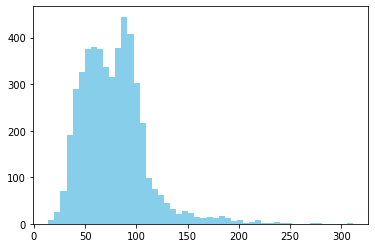

In [29]:
# 'encoded' 열의 각 리스트의 길이 계산
lengths = train_data['encoded'].apply(len)

print(f"Max Length: {lengths.max()}")
print(f"Min Length: {lengths.min()}")
print(f"Average Length: {lengths.mean()}")
print(f"Standard Deviation: {lengths.std()}")

# 길이 분포 시각화
plt.hist(lengths, bins=50, color='skyblue')
plt.show()

In [30]:
# 대화 최대 길이 128으로 설정
MAX_LENGTH = 128

In [31]:
X = pad_sequences(train_data['encoded'], maxlen=MAX_LENGTH, padding='post', truncating='post')
y = train_data['type']

In [32]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                  shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, 
                                                shuffle=True, random_state=42)

print('Number of training data:', len(X_train))
print('Number of training labels:', len(y_train))
print('Number of validation data:', len(X_val))
print('Number of validation labels:', len(y_val))
print('Number of test data:', len(X_test))
print('Number of test labels:', len(y_test))

Number of training data: 3960
Number of training labels: 3960
Number of validation data: 495
Number of validation labels: 495
Number of test data: 495
Number of test labels: 495


In [33]:
!pip install wandb==0.16.0

In [34]:
import wandb

In [35]:
wandb.login(key='8902458a7c74dce41823129a9fbd1f98e223198d')

wandb: Currently logged in as: godaebbang (letsgodaebbang). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /aiffel/.netrc


True

In [36]:
import wandb
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertModel, BertTokenizer, BertConfig

In [37]:
class CompareResultsCallback:
    def __init__(self, test_loader, y_test, class_num):
        self.test_loader = test_loader
        self.y_test = y_test
        self.class_num = class_num

    def plot_confusion_matrix(self, model, device):
        model.eval()
        pred_test = []
        with torch.no_grad():
            for X_test_batch, y_test_batch in self.test_loader:
                X_test_batch = X_test_batch.to(device)
                logits = model(X_test_batch)[1]
                pred = logits.argmax(dim=-1)
                pred_test.extend(pred.cpu().numpy())

        cm = confusion_matrix(self.y_test, pred_test)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    def __call__(self, model, device):
        self.plot_confusion_matrix(model, device)

In [38]:
class BertForSequenceClassification(nn.Module):
    def __init__(self, num_labels):
        super(BertForSequenceClassification, self).__init__()
        self.num_labels = num_labels
        self.config = BertConfig.from_pretrained("bert-base-multilingual-cased", num_labels=num_labels)
        self.bert = BertModel.from_pretrained("bert-base-multilingual-cased", config=self.config)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.config.hidden_size, num_labels)
        
    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]  # [CLS] 토큰의 출력 사용
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        
        return loss, logits

In [39]:
def prepare_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size):
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_val, y_val = np.array(X_val), np.array(y_val)
    X_test, y_test = np.array(X_test), np.array(y_test)

    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.long), torch.tensor(y_train, dtype=torch.long))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.long), torch.tensor(y_val, dtype=torch.long))
    test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.long), torch.tensor(y_test, dtype=torch.long))
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

In [40]:
def get_optimizer(optimizer_name, parameters, learning_rate):
    if optimizer_name == "adam":
        return torch.optim.Adam(parameters, lr=learning_rate)
    elif optimizer_name == "sgd":
        return torch.optim.SGD(parameters, lr=learning_rate)
    elif optimizer_name == "rmsprop":
        return torch.optim.RMSprop(parameters, lr=learning_rate)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

In [41]:
def train(default_config, X_train, y_train, X_val, y_val, X_test, y_test):
    wandb.init(config=default_config)
    config = wandb.config

    train_loader, val_loader, test_loader = prepare_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, config.batch_size)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BertForSequenceClassification(config.class_num).to(device)
    optimizer = get_optimizer(config.optimizer, model.parameters(), config.learning_rate)
    
    cm_callback = CompareResultsCallback(test_loader, y_test, config.class_num)
    
    for epoch in range(config.epoch):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            loss, logits = model(X_batch, labels=y_batch)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                loss, logits = model(X_val_batch, labels=y_val_batch)
                val_loss += loss.item()
                pred = logits.argmax(dim=-1)
                correct += (pred == y_val_batch).sum().item()
                total += y_val_batch.size(0)

        val_loss /= len(val_loader)
        accuracy = correct / total

        wandb.log({"val_loss": val_loss, "val_accuracy": accuracy})

    # 테스트 단계에서 confusion matrix 그리기
    cm_callback(model, device)

    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    pred_test = []
    with torch.no_grad():
        for X_test_batch, y_test_batch in test_loader:
            X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            loss, logits = model(X_test_batch, labels=y_test_batch)
            test_loss += loss.item()
            pred = logits.argmax(dim=-1)
            correct += (pred == y_test_batch).sum().item()
            total += y_test_batch.size(0)
            pred_test.extend(pred.cpu().numpy())

    test_loss /= len(test_loader)
    test_accuracy = correct / total
    f1_score_res = f1_score(y_test, pred_test, average='micro')

    wandb.log({
        "Test Accuracy Rate": test_accuracy,
        "Test F1 Score": f1_score_res,
        "Test Error Rate": 1 - test_accuracy
    })

In [42]:
def sweep_train():
    # 데이터 분할
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, shuffle=True, random_state=42)
    
    # y 데이터의 최대값 + 1 을 class_num으로 설정
    default_config["class_num"] = max(y) + 1
    
    train(default_config=default_config, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, X_test=X_test, y_test=y_test)

In [43]:
# 기본 설정
default_config = {
    "batch_size": 32,
    "epoch": 5,
    "learning_rate": 0.001,
    "optimizer": "adam",
    "class_num": 2  # 클래스 수 (필요에 따라 수정)
}

# 스윕 구성
sweep_config = {
    'method': 'random',
    'parameters': {
        'batch_size': {
            'values': [16, 32, 64]  # 배치 크기 줄이기
        },
        'epoch': {
            'values': [5, 6, 7, 8, 9, 10]
        },
        'learning_rate': {
            'max': 0.1,
            'min': 0.001
        },
        'optimizer': {
            'values': ['adam', 'sgd', 'rmsprop']
        }
    }
}

In [ ]:
# 스윕 생성 및 에이전트 실행
sweep_id = wandb.sweep(sweep_config, 
                       entity='aiffel_minions', 
                       project='DLthon_baseline_Bert')
wandb.agent(sweep_id, function=sweep_train, count=3)

Create sweep with ID: var4ykl7
Sweep URL: https://wandb.ai/aiffel_minions/DLthon_baseline_Bert/sweeps/var4ykl7


wandb: Agent Starting Run: k1c84j51 with config:
wandb: 	batch_size: 32
wandb: 	epoch: 8
wandb: 	learning_rate: 0.010106832869722584
wandb: 	optimizer: rmsprop
wandb: Currently logged in as: godaebbang (aiffel_minions). Use `wandb login --relogin` to force relogin


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
